# Kmeans Implementation

### Elbow Method Implementation

In [3]:
#implement elbow method from scratch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import accuracy_score

def elbow(trainX, trainy, valX, valy, method='km'):
    totalError=[]
    k=np.linspace(4,12,5).astype(int)
    if(method=='km'):
        km=Kmeans(trainX, trainy)
    elif(method=='kmpp'):
        km=Kmeansplusplus(trainX, trainy)
    for kval in k:
        print(f'k = {kval}')
        km.train(kval)
        km.test(valX)
        hs=homogeneity_score(km.ytrain, km.computedY)
        print(f'homogeneity_score for train: {hs}')
#         hs=accuracy_score(km.ytrain, km.computedY)
#         print(f'accuracy_score for train: {hs}\n')

        hs=homogeneity_score(valy, km.computed_valY)
        print(f'homogeneity_score for validation: {hs}')
#         hs=accuracy_score(valy, km.computed_valY)
#         print(f'accuracy_score for validation: {hs}\n\n')
        error=km.computeWSS()
        totalError.append(error)
    plt.plot(k,totalError)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WSS')  
    plt.title('Elbow Curve')
    plt.show()

### Silhouette Method Implementation

In [4]:
#implement silhouette method from scratch
def silhouette(trainX, trainy, valX,method='km'):
    if(method=='km'):
        km=Kmeans(trainX, trainy)
    elif(method=='kmpp'):
        km=Kmeansplusplus(trainX, trainy)
    totalError=[]
    k=np.linspace(4,12,5).astype(int)
    for kval in k:
        km.train(kval)
        km.test(valX)
        error=km.silhouette()
        totalError.append(error)
    plt.plot(k,totalError)    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')  
    plt.title('Silhouette Curve') 
    plt.show()    

## KMeans Implementation

In [5]:
#implement Kmeans from scratch
import sys
from sklearn.metrics.cluster import homogeneity_score
from sklearn.preprocessing import MinMaxScaler

def euclidean(vec1,vec2):
    #returns as many rows as in vec2
    #subtracts every row of vec2 from vec1(contains 1 row)
    vec=(vec1 - vec2)**2

    #for each row, sum the columns
    if(vec.ndim>=2):
        ans=np.sum(vec, axis=1)
    else:
        ans=np.sum(vec)
    return np.sqrt(ans)

def manhattanDist(vec1, vec2):
    vec=np.absolute(vec1 - vec2)
    if(vec.ndim>=2):
        return np.sum(vec, axis=1)
    else:
        return np.sum(vec)

class Kmeans(object):        
    def __init__(self, xtrain, ytrain, distance='l2'):
        self.k=0
        self.xtrain=xtrain.copy()
        self.ytrain=ytrain.copy()
        self.centroidData=None
        self.xtrain=self.xtrain.reshape(self.xtrain.shape[0],-1)
        self.distance=distance
#         print(self.xtrain.shape)
        
    def scaleData(self):
        mms = MinMaxScaler()
        self.xtrain=mms.fit_transform(self.xtrain)
    
    def forgy(self):
        rows,cols=self.xtrain.shape
        self.centroidData=np.empty(shape=(self.k, cols))       #k rows, 784 cols
        centroidIndex = np.random.choice(rows, self.k, replace=False)     #choose k indexes at random
        i=0
#         print(np.shape(self.X[centroidIndex[0]].reshape(1,-1)))
        for centroid in centroidIndex:
            self.centroidData[i]=self.X[centroid][:-2].reshape(1,-1)         #copy the data at the selected k indices to centroidData
            i+=1
        
    def random_partition(self):
        rows,cols=self.xtrain.shape
        self.centroidData=np.empty(shape=(self.k, cols))       #k rows, 784 cols
        self.X[:,-1] = np.random.choice(range(0, self.k), replace = True, size = rows)
        for i in range(self.k):
            self.centroidData[i]=self.X[self.X[:,-1] == i, :-2].mean(axis=0)

    def findCluster(self, dist, clusterId):
        for i in range(len(dist)):
            if(self.X[i][-2]>dist[i]):
                self.X[i][-2]=dist[i]
                self.X[i][-1]=clusterId
   
    def train(self, k, init_method='forgy'):
        self.k=k
        max_iter=100              #maximum iterations allowed - after these iterations even if the centroids don't converge, STOP
        totalError=0
#         print(np.shape(self.xtrain))
        rows, cols = np.shape(self.xtrain)
        minDist=np.full((rows,1), sys.maxsize, dtype='float')         #dist
        finalCluster=np.full((rows,1), -1, dtype='int8')              #cluster
        ytrain=np.concatenate((minDist, finalCluster), axis=1)                   #dist,cluster
        self.X=np.append(self.xtrain, ytrain, axis=1)      #flattened the input data - 28X28 dim values to 1X784 and appended distance and clusterId the row belongs to
#         print(np.shape(self.X))

        #initialize centroid
        if(init_method=='forgy'):
            self.forgy()
        elif(init_method=='random_part'):
            self.random_partition()

        change=True                    #To check if any of the centroids changed
        count=0                        #Counts the number of iterations
        while(change):
#             print(count)
            for idx in range(self.k):                 #find the distance of each point from each cluster centre
                if(self.distance=='l2'):
                    dist=np.apply_along_axis(euclidean, 1, self.centroidData[idx].reshape(1,-1), self.X[:,:-2])
                elif (self.distance=='l1'):
                    dist=np.apply_along_axis(manhattanDist, 1, self.centroidData[idx].reshape(1,-1), self.X[:,:-2])
                self.findCluster(dist.T, idx)      #check if distance less than the distance from previous cluster center and update the cluster center

            threshold=1          #margin of change allowed in the centroid
            change=False
            for i in range(self.k):
                group=self.X[self.X[:,-1].astype('int')==i]         #group rows which have the same clusterId
                #take mean to find centroid
        #         print(np.shape(group))
                newCentre=np.mean(group[:,:-2], axis=0)            #new Centroid
                if(self.distance=='l2'):
                    error=euclidean(newCentre,self.centroidData[i])    #distance between the new centroid and the current centroid
                elif(self.distance=='l1'):
                    error=manhattanDist(newCentre,self.centroidData[i])    #distance between the new centroid and the current centroid
                if(error>threshold and count<max_iter):
                    change=True
                    self.centroidData[i]=newCentre            

            count+=1
        self.computedY=self.X[:,-1]
#         return self.computedY

    def computeWSS(self): 
        totalError=0
        for i in range(self.k):
            groupIdx=list(self.computed_valY.astype('int')==i)
            if(self.distance=='l2'):
                dist=euclidean(self.centroidData[i].reshape(1,-1), self.valX[groupIdx])
            elif(self.distance=='l1'):
                dist=manhattanDist(self.centroidData[i].reshape(1,-1), self.valX[groupIdx])
            error=np.sum(dist**2)
            totalError+=error
        return totalError
            
    def minDistCluster(self, point, centroid):
        if(self.distance=='l2'):
#             return np.argmin(np.linalg.norm((point-centroid), axis=1))
            return np.argmin(euclidean(point,centroid))
        elif(self.distance=='l1'):
            return np.argmin(manhattanDist(point,centroid))

    #nearest cluster from current cluster
    def minDistCC(self, curCentroid, centroid):
        mask=np.full(self.k, True, dtype='bool')
        if(self.distance=='l2'):
            dist=euclidean(curCentroid,centroid)
        elif(self.distance=='l1'):
            dist=manhattanDist(curCentroid,centroid)
        minIdx=np.argmin(dist)
        mask[minIdx]=False
        secondIdx=np.argmin(dist[mask])
        if(secondIdx>=minIdx):
            return secondIdx+1
        else:
            return secondIdx

    def test(self, valX):
        self.valX=valX.copy()
        self.valX=self.valX.reshape(np.shape(self.valX)[0],-1)
        self.computed_valY=np.apply_along_axis(self.minDistCluster, 1, self.valX, self.centroidData)
#         return self.computed_valY
        
    def silhouette(self):
        error=0
        #find min distance cluster Centre for each cluster
        minDistCC=np.apply_along_axis(self.minDistCC, 1, self.centroidData, self.centroidData)
        
        for i in range(np.shape(self.valX)[0]):
            clusterId=self.computed_valY[i]
            groupIdx=list(self.computed_valY.astype('int')==clusterId)
            if(self.distance=='l2'):
                a=np.sum(euclidean(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)
            elif(self.distance=='l1'):
                a=np.sum(manhattanDist(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)

            nearClusterId=minDistCC[clusterId]
            groupIdx=list(self.computed_valY.astype('int')==nearClusterId)
            if(self.distance=='l2'):
                b=np.sum(euclidean(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)            
            elif(self.distance=='l1'):
                b=np.sum(manhattanDist(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)            
            
            error+=((b-a)/max(a,b))
            
        return error/np.shape(self.valX)[0]


### Silhouette Curve for KMeans
Optimal K = 10

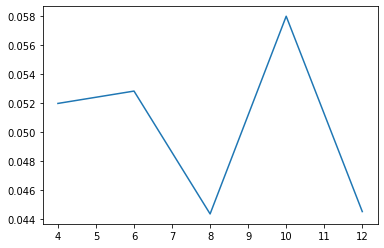

In [33]:
silhouette(trainX, trainy, valX, 'km')

### Elbow Curve for KMeans
Optimal K = 10

k = 4
homogeneity_score for train: 0.36434635218406275
accuracy_score for train: 0.14204081632653062

homogeneity_score for validation: 0.3308996458122556
accuracy_score for validation: 0.14809523809523809


k = 6
homogeneity_score for train: 0.3797092384513551
accuracy_score for train: 0.17189795918367348

homogeneity_score for validation: 0.39234421509661865
accuracy_score for validation: 0.16547619047619047


k = 8
homogeneity_score for train: 0.40469183352131444
accuracy_score for train: 0.07944897959183674

homogeneity_score for validation: 0.40997140350280087
accuracy_score for validation: 0.0668095238095238


k = 10
homogeneity_score for train: 0.49015647250699557
accuracy_score for train: 0.2050612244897959

homogeneity_score for validation: 0.503655546571518
accuracy_score for validation: 0.20514285714285715


k = 12
homogeneity_score for train: 0.48274692917932877
accuracy_score for train: 0.21206122448979592

homogeneity_score for validation: 0.5016944132470169
accuracy_scor

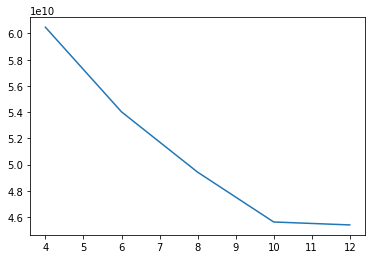

In [26]:
elbow(trainX, trainy, valX, valy, 'km')

### OPTIMAL K 
Optimal K for Kmeans using silhouette method and elbow method is coming to be 10

Following is the experimentation for KMeans with k=10 and different distance measures and centroid initialisation methods

### KMeans with Random Initialisation and Euclidean Distance

In [12]:
optimalk=10
km=Kmeans(trainX, trainy)
km.train(optimalk,'random_part')
km.test(valX)

print(f'k = {optimalk}, Partition: Random Partition, Distance: Euclidean\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(km.ytrain, km.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, km.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

k = 10, Partition: Random Partition, Distance: Euclidean

homogeneity_score for train: 0.5182086917052001
accuracy_score for train: 0.03514285714285714

homogeneity_score for validation: 0.5178104748042125
accuracy_score for validation: 0.04




### KMeans with Forgy Initialisation and Manhattan Distance

In [12]:
optimalk=10
km=Kmeans(trainX, trainy,'l1')
km.train(optimalk,'forgy')
km.test(valX)

print(f'k = {optimalk}, Partition: Forgy, Distance: Manhattan\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(km.ytrain, km.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, km.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

k = 10, Partition: Forgy, Distance: Manhattan

homogeneity_score for train: 0.45511151315782655
accuracy_score for train: 0.02610204081632653

homogeneity_score for validation: 0.45381086317660807
accuracy_score for validation: 0.028285714285714286




### KMeans with Random Initialisation and Manhattan Distance

In [17]:
optimalk=10
km=Kmeans(trainX, trainy,'l1')
km.train(optimalk,'random_part')
km.test(valX)

print(f'k = {optimalk}, Partition: Random Partition, Distance: Manhattan\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(km.ytrain, km.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, km.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

k = 10, Partition: Random Partition, Distance: Manhattan

homogeneity_score for train: 0.49572789649106014
accuracy_score for train: 0.13904081632653062

homogeneity_score for validation: 0.4942021865722341
accuracy_score for validation: 0.14376190476190476




### KMeans (normalised data)  with Forgy Initialisation and Manhattan Distance

Normalising data doesn't change the accuracy since the data is images and value in every dimension will lie in (0,255). Since the scale is same in all dimensions, normalisation will not change accuracy.

In [16]:
optimalk=10
km=Kmeans(trainX, trainy,'l1')
km.scaleData()
km.train(optimalk,'forgy')
km.test(valX)

print(f'Scaled Data, k = {optimalk}, Partition: Forgy, Distance: Manhattan\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(km.ytrain, km.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, km.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

Scaled Data, k = 10, Partition: Forgy, Distance: Manhattan

homogeneity_score for train: 0.4236214775346896
accuracy_score for train: 0.08038775510204081

homogeneity_score for validation: 0.4477144545999592
accuracy_score for validation: 0.032523809523809524




### SKlearn KMeans  with Random Centroid Initialisation and Elbow Curve
The Sklearn kmeans algorithm gives a little better accuracy than the one I implemented. Also the execution time for the inbuilt algorithm is lesser.

Optimal K using elbow method for inbuilt Kmeans is coming to be 8

k=4, Homogeneity Score: 0.5367181116334669
k=6, Homogeneity Score: 0.5459161707264732
k=8, Homogeneity Score: 0.5347690814128373
k=10, Homogeneity Score: 0.519988787868991
k=12, Homogeneity Score: 0.5095269497819035


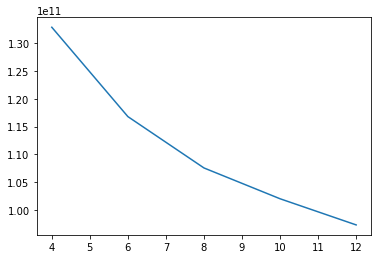

In [27]:
#Sklearn Kmeans
from sklearn.cluster import KMeans

totalError=[]
k=np.linspace(4,12,5).astype(int)
for kval in k:
    km = KMeans(n_clusters=kval, init='random', n_init=1, max_iter=300, random_state=0)
    y_km = km.fit_predict(trainX.reshape(np.shape(trainX)[0],-1))
    hs=homogeneity_score(y_km, trainy)
    print(f'k={kval}, Homogeneity Score: {hs}')
    totalError.append(km.inertia_)

plt.plot(k,totalError)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')  
plt.title('Elbow Curve Inbuilt KMeans')

## KMeans++ Implementation

In [78]:
#implement Kmeans++ from scratch

class Kmeansplusplus(object):
    def __init__(self, xtrain, ytrain, distance='l2'):
        self.k=0
        self.xtrain=xtrain.copy()
        self.ytrain=ytrain.copy()
        self.centroidData=None
        self.xtrain=self.xtrain.reshape(self.xtrain.shape[0],-1)
        self.distance=distance
#         print(self.xtrain.shape)
        
    def scaleData(self):
        mms = MinMaxScaler()
        self.xtrain=mms.fit_transform(self.xtrain)    

    def init_centroid(self):
        rows, cols = np.shape(self.xtrain)
        self.centroidData=np.empty(shape=(self.k,cols))
        i=0
        centroidIdx = np.random.choice(rows, 1, replace=False)     #choose 1 index at random
        mask = np.ones(rows, bool)
        mask[centroidIdx] = False
        while(i<self.k):
            self.centroidData[i]=self.xtrain[centroidIdx,:]
            if(self.distance=='l2'):
                dist=np.apply_along_axis(euclidean, 1, self.centroidData[i].reshape(1,-1), self.xtrain)
            elif(self.distance=='l1'):
                dist=np.apply_along_axis(manhattanDist, 1, self.centroidData[i].reshape(1,-1), self.xtrain)
                
            dist=dist**2
            centroidIdx=np.argmax(dist[:,mask])
            mask[centroidIdx] = False
            i+=1
        
    def findCluster(self, dist, clusterId):
        for i in range(len(dist)):
            if(self.X[i][-2]>dist[i]):
                self.X[i][-2]=dist[i]
                self.X[i][-1]=clusterId
   
    def train(self, k):
        self.k=k
        max_iter=100              #maximum iterations allowed - after these iterations even if the centroids don't converge, STOP
#         print(np.shape(self.xtrain))
        rows, cols = np.shape(self.xtrain)
        minDist=np.full((rows,1), sys.maxsize, dtype='float')         #dist
        finalCluster=np.full((rows,1), -1, dtype='int8')              #cluster
        ytrain=np.concatenate((minDist, finalCluster), axis=1)                   #dist,cluster
        self.X=np.append(self.xtrain, ytrain, axis=1)      #flattened the input data - 28X28 dim values to 1X784 and appended distance and clusterId the row belongs to

        #initialize centroid
        self.init_centroid()

        change=True                    #To check if any of the centroids changed
        count=0                        #Counts the number of iterations
        while(change):
#             print(count)
            for idx in range(self.k):                 #find the distance of each point from each cluster centre
                if(self.distance=='l2'):
                    dist=np.apply_along_axis(euclidean, 1, self.centroidData[idx].reshape(1,-1), self.X[:,:-2])
                elif(self.distance=='l1'):
                    dist=np.apply_along_axis(manhattanDist, 1, self.centroidData[idx].reshape(1,-1), self.X[:,:-2])
                self.findCluster(dist.T, idx)      #check if distance less than the distance from previous cluster center and update the cluster center

            threshold=0.05          #margin of change allowed in the centroid (5% of max distance)
            change=False
            for i in range(self.k):
                group=self.X[self.X[:,-1].astype('int')==i]         #group rows which have the same clusterId
                #take mean to find centroid
                newCentre=np.mean(group[:,:-2], axis=0)            #new Centroid
                if(self.distance=='l2'):
                    error=euclidean(newCentre,self.centroidData[i])    #distance between the new centroid and the current centroid
                elif(self.distance=='l1'):
                    error=manhattanDist(newCentre,self.centroidData[i])    #distance between the new centroid and the current centroid
                if(error>threshold and count<max_iter):
                    change=True
                    self.centroidData[i]=newCentre            

            count+=1

        self.computedY=self.X[:,-1]

    def test(self, valX):
        self.valX=valX.copy()
        self.valX=self.valX.reshape(np.shape(self.valX)[0],-1)
        self.computed_valY=np.apply_along_axis(self.minDistCluster, 1, self.valX, self.centroidData)

    def computeWSS(self): 
        totalError=0
        for i in range(self.k):
            groupIdx=list(self.computed_valY.astype('int')==i)
            if(self.distance=='l2'):
                dist=euclidean(self.centroidData[i].reshape(1,-1), self.valX[groupIdx])
            elif(self.distance=='l1'):
                dist=manhattanDist(self.centroidData[i].reshape(1,-1), self.valX[groupIdx])
            error=np.sum(dist**2)
            totalError+=error
        return totalError

    def minDistCluster(self, point, centroid):
        if(self.distance=='l2'):
            return np.argmin(euclidean(point,centroid))
        elif(self.distance=='l1'):
            return np.argmin(manhattanDist(point,centroid))

    #nearest cluster from current cluster
    def minDistCC(self, curCentroid, centroid):
        mask=np.full(self.k, True, dtype='bool')
        if(self.distance=='l2'):
            dist=euclidean(curCentroid,centroid)
        elif(self.distance=='l1'):
            dist=manhattanDist(curCentroid,centroid)
        minIdx=np.argmin(dist)
        mask[minIdx]=False
        secondIdx=np.argmin(dist[mask])
        if(secondIdx>=minIdx):
            return secondIdx+1
        else:
            return secondIdx
    
    def silhouette(self):
        error=0
        #find min distance cluster Centre for each cluster
        minDistCC=np.apply_along_axis(self.minDistCC, 1, self.centroidData, self.centroidData)
        
        for i in range(np.shape(self.valX)[0]):
            clusterId=self.computed_valY[i]
            groupIdx=list(self.computed_valY.astype('int')==clusterId)
            if(self.distance=='l2'):
                a=np.sum(euclidean(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)
            elif(self.distance=='l1'):
                a=np.sum(manhattanDist(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)

            nearClusterId=minDistCC[clusterId]
            groupIdx=list(self.computed_valY.astype('int')==nearClusterId)
            if(self.distance=='l2'):
                b=np.sum(euclidean(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)            
            elif(self.distance=='l1'):
                b=np.sum(manhattanDist(self.valX[i].reshape(1,-1), self.valX[groupIdx]))/np.count_nonzero(groupIdx)            
            
            error+=((b-a)/max(a,b))
            
        return error/np.shape(self.valX)[0]

### Silhouette and Elbow Curves for Kmeans++

Optimal K is coming to be 10 using silhouette method and 8 using elbow method.

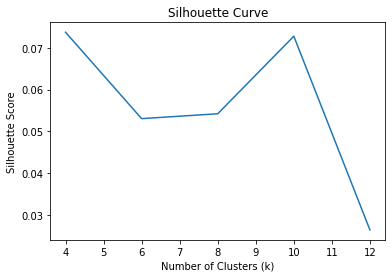

k = 4
homogeneity_score for train: 0.2912277384270236
homogeneity_score for validation: 0.30217149747895344
k = 6
homogeneity_score for train: 0.39841641621946156
homogeneity_score for validation: 0.39613084582663
k = 8
homogeneity_score for train: 0.4470126557690072
homogeneity_score for validation: 0.45646097756432175
k = 10
homogeneity_score for train: 0.44546843681590187
homogeneity_score for validation: 0.466279943679997
k = 12
homogeneity_score for train: 0.5310771608566915
homogeneity_score for validation: 0.5423168535189676


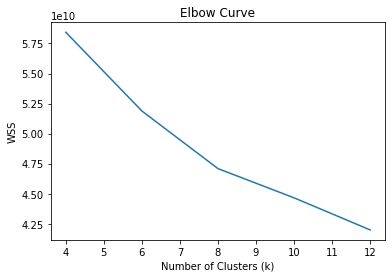

In [88]:
#Find optimal k for kmeans++
silhouette(trainX, trainy, valX,'kmpp')
elbow(trainX, trainy, valX, valy,'kmpp')

### Optimal K = 10
Following is experimentation for KMeans with K=10 and different distance measures 

### Kmeans++ with Euclidean Distance

In [23]:
optimalk=10
kmpp=Kmeansplusplus(trainX, trainy)
kmpp.train(optimalk)
kmpp.test(valX)

print(f'KMeans++\nk = {optimalk}, Distance: Euclidean\n')
hs=homogeneity_score(kmpp.ytrain, kmpp.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(kmpp.ytrain, kmpp.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, kmpp.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, kmpp.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

KMeans++
k = 10, Distance: Euclidean

homogeneity_score for train: 0.4889792076313156
accuracy_score for train: 0.07855102040816327

homogeneity_score for validation: 0.5108280534104929
accuracy_score for validation: 0.08647619047619047




### Kmeans++ with Manhattan Distance

In [24]:
optimalk=10
kmpp=Kmeansplusplus(trainX, trainy,'l1')
kmpp.train(optimalk)
kmpp.test(valX)

print(f'KMeans++\nk = {optimalk}, Distance: Manhattan\n')
hs=homogeneity_score(kmpp.ytrain, kmpp.computedY)
print(f'homogeneity_score for train: {hs}')
hs=accuracy_score(kmpp.ytrain, kmpp.computedY)
print(f'accuracy_score for train: {hs}\n')

hs=homogeneity_score(valy, kmpp.computed_valY)
print(f'homogeneity_score for validation: {hs}')
hs=accuracy_score(valy, kmpp.computed_valY)
print(f'accuracy_score for validation: {hs}\n\n')

KMeans++
k = 10, Distance: Manhattan

homogeneity_score for train: 0.457978012689498
accuracy_score for train: 0.10504081632653062

homogeneity_score for validation: 0.46033917829300175
accuracy_score for validation: 0.10785714285714286




### Sklearn KMeans++
The Sklearn kmeans++ algorithm gives a little better accuracy than the one I implemented. Also the execution time for the inbuilt algorithm is lesser.

Optimal K is coming to be 10 using elbow method with inbuilt Kmeans++

k=4, Homogeneity Score: 0.537334220704837
k=6, Homogeneity Score: 0.5459894364845559
k=8, Homogeneity Score: 0.5048274870804283
k=10, Homogeneity Score: 0.5176703960777586
k=12, Homogeneity Score: 0.5255208199092422


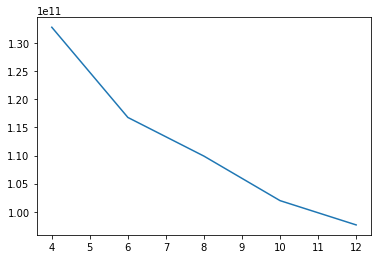

In [25]:
#Sklearn Kmeans
from sklearn.cluster import KMeans

totalError=[]
k=np.linspace(4,12,5).astype(int)
for kval in k:
    km = KMeans(n_clusters=kval, init='k-means++', n_init=1, max_iter=300, random_state=0)
    y_km = km.fit_predict(trainX.reshape(np.shape(trainX)[0],-1))
    hs=homogeneity_score(y_km, trainy)
    print(f'k={kval}, Homogeneity Score: {hs}')
    totalError.append(km.inertia_)

plt.plot(k,totalError)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')  
plt.title('Elbow Curve Inbuilt KMeans++')

## Load and Partition Data for Part 1

In [83]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [84]:
import numpy as np
from sklearn.model_selection import train_test_split

trainX=np.append(trainX, testX, axis=0)
trainy=np.append(trainy, testy, axis=0)

#Split Data
trainX , valX, trainy, valy = train_test_split(trainX, trainy, test_size = 0.3)

### Data Visualisation using TSNE

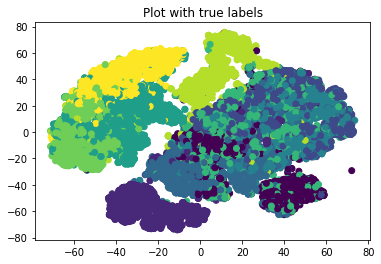

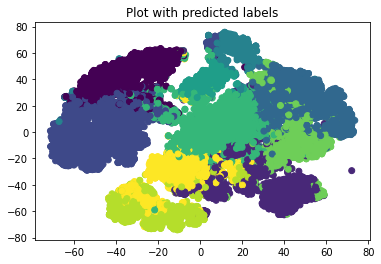

In [15]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(valX.reshape(np.shape(valX)[0],-1))

plt.scatter(*zip(*X_embedded),c=valy)
plt.title('Plot with true labels')
plt.show()
plt.scatter(*zip(*X_embedded),c=km.computed_valY)
plt.title('Plot with predicted labels')
plt.show()

# PART 2

### Load Data and Split into Test and Train

In [7]:
import pandas as pd
df=pd.read_csv('data.csv', header=None)
df.iloc[:,0]=df.iloc[:,0].apply(lambda x: x.strip('['))
df.iloc[:,-2]=df.iloc[:,-2].apply(lambda x: x.strip(']'))
df.iloc[:,-1] = pd.Categorical(df.iloc[:,-1])
df.iloc[:,-1]=df.iloc[:,-1].cat.codes

X=df.iloc[:,:-1].to_numpy(dtype='float')
y=df.iloc[:,-1].to_numpy()

In [8]:
from sklearn.model_selection import train_test_split

#Split Data
trainX , testX, trainy, testy = train_test_split(X, y, test_size = 0.3)

### Silhouette Curve for KMeans
Optimal K = 8

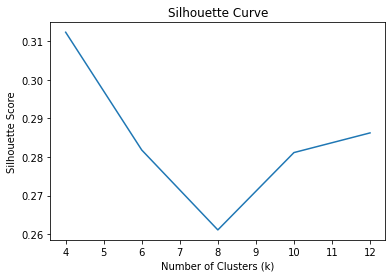

In [44]:
silhouette(trainX, trainy, testX, 'km')

### Elbow Curve for Kmeans
Optimal K = 10

k = 4
homogeneity_score for train: 0.2280284630881822
homogeneity_score for validation: 0.2298077828180827
k = 6
homogeneity_score for train: 0.28743123031011364
homogeneity_score for validation: 0.3147537560608952
k = 8
homogeneity_score for train: 0.37643931570243444
homogeneity_score for validation: 0.37721827807960057
k = 10
homogeneity_score for train: 0.436915196858794
homogeneity_score for validation: 0.45071771611242734
k = 12
homogeneity_score for train: 0.45365151653880165
homogeneity_score for validation: 0.4598052541000865


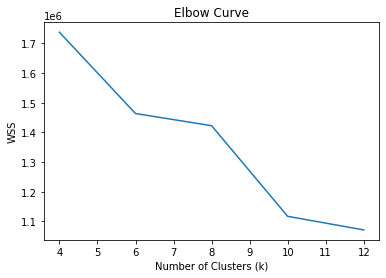

In [9]:
elbow(trainX, trainy, testX, testy, 'km')

### OPTIMAL K
Optimal K is coming to be 10 with the elbow method and 8 with silhouette method.

Following is the experimentation for Kmeans with K=10 and different centroid initialisation methods and distance measures

### KMeans (Normalised Data) with Forgy Initialisation and Euclidean Distance
Normalising the data does not change the accuracy of clustering since the data has the same scale in all the dimensions

In [66]:
optimalk=10
km=Kmeans(trainX, trainy)
km.scaleData()
km.train(optimalk,'forgy')
km.test(testX)

print(f'Scaled KMeans\nk = {optimalk}, Partition: Forgy, Distance: Euclidean\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')

hs=homogeneity_score(testy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')

Scaled KMeans
k = 10, Partition: Forgy, Distance: Euclidean

homogeneity_score for train: 0.47283216868327765
homogeneity_score for validation: 0.35135173589975477


### KMeans with Forgy Initialisation and Euclidean Distance

In [67]:
optimalk=10
km=Kmeans(trainX, trainy)
km.train(optimalk,'forgy')
km.test(testX)

print(f'KMeans\nk = {optimalk}, Partition: Forgy, Distance: Euclidean\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')

hs=homogeneity_score(testy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')

KMeans
k = 10, Partition: Forgy, Distance: Euclidean

homogeneity_score for train: 0.4392476119208344
homogeneity_score for validation: 0.4419558830374042


### KMeans with Random Initialisation and Manhattan Distance

In [38]:
optimalk=10
km=Kmeans(trainX, trainy, 'l1')
km.train(optimalk,'random_part')
km.test(testX)

print(f'KMeans\nk = {optimalk}, Partition: Random Partition, Distance: Manhattan\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')

hs=homogeneity_score(testy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')

KMeans
k = 10, Partition: Random Partition, Distance: Manhattan

homogeneity_score for train: 0.4579984243235301
homogeneity_score for validation: 0.466167562234096


### Silhouette Curve and Elbow Curve for KMeans++
Optimal K = 10

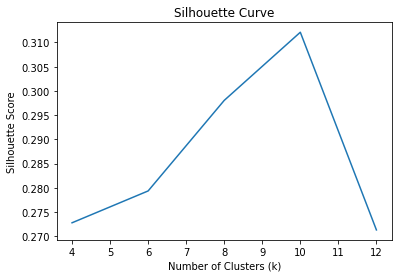

k = 4
homogeneity_score for train: 0.26344413039093667
homogeneity_score for validation: 0.26497098585087686
k = 6
homogeneity_score for train: 0.35419857013883227
homogeneity_score for validation: 0.3558127861864929
k = 8
homogeneity_score for train: 0.36422607903111
homogeneity_score for validation: 0.37760582783625035
k = 10
homogeneity_score for train: 0.4484428387261853
homogeneity_score for validation: 0.4548558248755077
k = 12
homogeneity_score for train: 0.484240911219196
homogeneity_score for validation: 0.49008658209363365


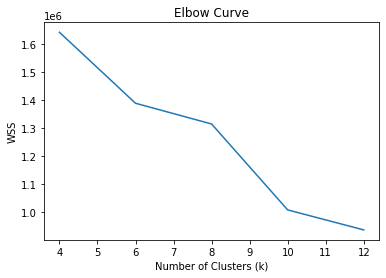

In [82]:
#Find optimal k for kmeans++
silhouette(trainX, trainy, testX,'kmpp')
elbow(trainX, trainy, testX, testy,'kmpp')

### OPTIMAL K
Optimal K is coming to be 10 using elbow and silhouette methods

### KMeans++ with Euclidean Distance

In [41]:
optimalk=10
km=Kmeansplusplus(trainX, trainy, 'l2')
km.train(optimalk)
km.test(testX)

print(f'KMeans++\nk = {optimalk}, Distance: Euclidean\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')

hs=homogeneity_score(testy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')

KMeans++
k = 10, Distance: Euclidean

homogeneity_score for train: 0.40437685893423053
homogeneity_score for validation: 0.41067223090746063


### KMeans++ with Manhattan Distance

In [42]:
optimalk=10
km=Kmeansplusplus(trainX, trainy, 'l1')
km.train(optimalk)
km.test(testX)

print(f'KMeans++\nk = {optimalk}, Distance: Manhattan\n')
hs=homogeneity_score(km.ytrain, km.computedY)
print(f'homogeneity_score for train: {hs}')

hs=homogeneity_score(testy, km.computed_valY)
print(f'homogeneity_score for validation: {hs}')

KMeans++
k = 10, Distance: Manhattan

homogeneity_score for train: 0.4360058466920865
homogeneity_score for validation: 0.448030447267976


### Sklearn KMeans
The Sklearn kmeans algorithm gives a little better accuracy than the one I implemented. Also the execution time for the inbuilt algorithm is lesser.

Optimal K is coming to be 8 using elbow method with inbuilt Kmeans method

k=4, Homogeneity Score: 0.4779614194512419
k=6, Homogeneity Score: 0.48781809147566835
k=8, Homogeneity Score: 0.5095906597726122
k=10, Homogeneity Score: 0.4780631054451721
k=12, Homogeneity Score: 0.4574793418756973


Text(0.5, 1.0, 'Elbow Curve Inbuilt KMeans')

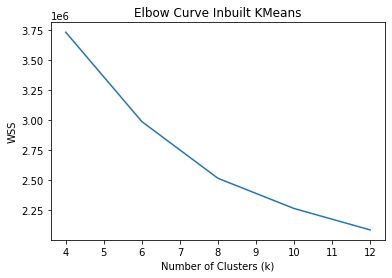

In [45]:
#Sklearn Kmeans
from sklearn.cluster import KMeans

totalError=[]
k=np.linspace(4,12,5).astype(int)
for kval in k:
    km = KMeans(n_clusters=kval, init='random', n_init=1, max_iter=300, random_state=0)
    y_km = km.fit_predict(trainX.reshape(np.shape(trainX)[0],-1))
    hs=homogeneity_score(y_km, trainy)
    print(f'k={kval}, Homogeneity Score: {hs}')
    totalError.append(km.inertia_)

plt.plot(k,totalError)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')  
plt.title('Elbow Curve Inbuilt KMeans')

### Sklearn KMeans++
The Sklearn kmeans++ algorithm gives a little better accuracy than the one I implemented. Also the execution time for the inbuilt algorithm is lesser.

Optimal K is coming to be 8 using elbow method with inbuilt Kmeans++ method

k=4, Homogeneity Score: 0.47796974947395704
k=6, Homogeneity Score: 0.4889358887099507
k=8, Homogeneity Score: 0.5095264849927668
k=10, Homogeneity Score: 0.47741857633163926
k=12, Homogeneity Score: 0.46482289693313694


Text(0.5, 1.0, 'Elbow Curve Inbuilt KMeans++')

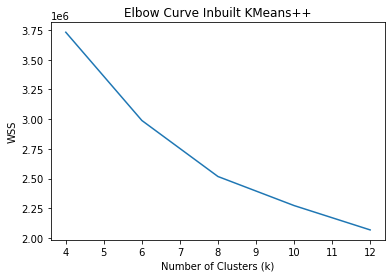

In [46]:
#Sklearn Kmeans
from sklearn.cluster import KMeans

totalError=[]
k=np.linspace(4,12,5).astype(int)
for kval in k:
    km = KMeans(n_clusters=kval, init='k-means++', n_init=1, max_iter=300, random_state=0)
    y_km = km.fit_predict(trainX.reshape(np.shape(trainX)[0],-1))
    hs=homogeneity_score(y_km, trainy)
    print(f'k={kval}, Homogeneity Score: {hs}')
    totalError.append(km.inertia_)

plt.plot(k,totalError)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')  
plt.title('Elbow Curve Inbuilt KMeans++')

### Data Visualisation with TSNE

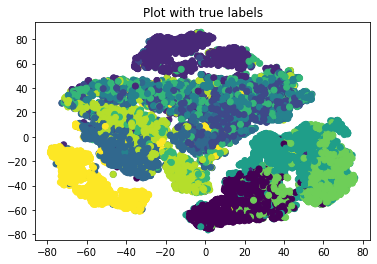

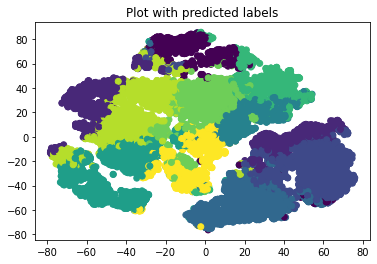

In [68]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(testX.reshape(np.shape(testX)[0],-1))

plt.scatter(*zip(*X_embedded),c=testy)
plt.title('Plot with true labels')
plt.show()
plt.scatter(*zip(*X_embedded),c=km.computed_valY)
plt.title('Plot with predicted labels')
plt.show()

# Comparision (Part1 and Part2)

The accuracies for Part1 and Part2 data vary very little but the running time for the algorithm is significantly less for dataset in Part2.